In [1]:
#Insert TPU activity into https://www.kaggle.com/yasufuminakama/ranzcr-resnext50-32x4d-starter-training
#Refered to TPU implementation https://www.kaggle.com/dimitreoliveira/cassava-leaf-disease-tpu-tensorflow-training
#Refered to XLA documentation(and code) https://pytorch.org/xla/release/1.8/index.html 


#Hardware settings

##Colab Only

In [2]:
#Check TPU status
import os
from tensorflow.python.profiler import profiler_client

tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
print(profiler_client.monitor(tpu_profile_service_address, 100, 2))

  No data collected. Perhaps, nothing is being executed on the TPU?




In [3]:
#Check GPU status
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [4]:
#Check Memory size
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 38.0 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
#Connect Google drive
from google.colab import drive
drive.mount('/content/drive')
! mkdir -p ~/.kaggle
! cp "drive/My Drive/kaggle/kaggle.json" ~/.kaggle/
!pip install --upgrade --force-reinstall --no-deps kaggle
! kaggle config view
ROOT_DIR="/content/drive/MyDrive"
INPUT_DIR="/kaggle/input"
%cd $ROOT_DIR$INPUT_DIR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303/kaggle-1.5.12-cp37-none-any.whl
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
Configuration values from /root/.kaggle
- username: roganzu
- path: None
- proxy: None
- competition: None
/content/drive/MyDrive/kaggle/input


##TPU setting

In [6]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

#Dependencies

In [7]:
!pip install timm

In [8]:
!pip install --upgrade --force-reinstall --no-deps albumentations

  Using cached https://files.pythonhosted.org/packages/03/58/63fb1d742dc42d9ba2800ea741de1f2bc6bb05548d8724aa84794042eaf2/albumentations-0.5.2-py3-none-any.whl
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


In [9]:
import numpy as np
import os
import time
import random

import torch
import torch.nn as nn
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
from torchvision import datasets, transforms

import pandas as pd
import cv2
from matplotlib import pyplot as plt

import timm

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import math
import datetime

In [10]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch()

#Parameters(Non-tuning)

In [11]:
FLAGS = {}
FLAGS['REPO_NAME'] = 'plant-pathology-2021-fgvc8'
#data
FLAGS['OS_LIST_DIR'] = f"../input/{FLAGS['REPO_NAME']}"
FLAGS['TRAIN_PATH'] = f"{FLAGS['OS_LIST_DIR']}/train_images"
FLAGS['image_size'] = 600
#model
FLAGS['model_name'] = 'resnext50_32x4d'
FLAGS['target_size'] = 12
#output
FLAGS['OUTPUT_DIR'] = f"{ROOT_DIR}/kaggle/output/{FLAGS['REPO_NAME']}/pth/"

#LoadData

In [12]:
os.listdir(FLAGS['OS_LIST_DIR'] )

['sample_submission.csv',
 'train.csv',
 'plant-pathology-2021-fgvc8.zip',
 'test_images',
 'train_images']

In [13]:
database_base_path = '../input/plant-pathology-2021-fgvc8/'
train = pd.read_csv(f'{database_base_path}train.csv')
print(f'Train samples: {len(train)}')

Train samples: 18632


In [14]:
train.head(10)

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
5,800edef467d27c15.jpg,healthy
6,800f85dc5f407aef.jpg,cider_apple_rust
7,801d6dcd96e48ebc.jpg,healthy
8,801f78399a44e7af.jpg,complex
9,8021b94d437eb7d3.jpg,healthy


#EDA

In [15]:
train.describe()

,image,labels
count,18632,18632
unique,18632,12
top,8a27d495855e55da.jpg,scab
freq,1,4826


In [16]:
display(train.groupby('labels', as_index=False).count())

,labels,image
0,cider_apple_rust,1860
1,complex,1602
2,frog_eye_leaf_spot,3181
3,frog_eye_leaf_spot complex,165
4,healthy,4624
5,powdery_mildew,1184
6,powdery_mildew complex,87
7,rust complex,97
8,rust frog_eye_leaf_spot,120
9,scab,4826


In [17]:
labels = list(train['labels'].value_counts().keys())
labels_dict = dict(zip(labels, range(12)))
train['labels'] = train['labels'].replace(labels_dict)
train.head()

,image,labels
0,800113bb65efe69e.jpg,1
1,8002cb321f8bfcdf.jpg,7
2,80070f7fb5e2ccaa.jpg,0
3,80077517781fb94f.jpg,0
4,800cbf0ff87721f8.jpg,4


#Augmentation

In [18]:
#Update later

#Model

In [19]:
class CustomModel(nn.Module):
    def __init__(self, model_name=FLAGS['model_name'], pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, FLAGS['target_size'])

    def forward(self, x):
        x = self.model(x)
        return x


In [20]:
SERIAL_EXEC = xmp.MpSerialExecutor()
WRAPPED_MODEL = xmp.MpModelWrapper(CustomModel())

#Util

In [21]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%02dm %02ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (Remain %s)' % (asMinutes(s), asMinutes(rs))

#Training

##Transforming

In [22]:
def get_transforms(*, data): 
        return Compose([
            RandomResizedCrop(FLAGS['image_size'], FLAGS['image_size'], scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [23]:
class TrainDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.file_names = df['image'].values
    self.labels = df['labels'].values
    self.transform = transform
        
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    file_name = self.file_names[idx]
    file_path = f"{FLAGS['TRAIN_PATH']}/{file_name}"
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if self.transform:
      augmented = self.transform(image=image)
      image = augmented['image']
      label = torch.tensor(self.labels[idx]).float()
    return image, label

  def __call__(self):
    print('callable is called')
    return

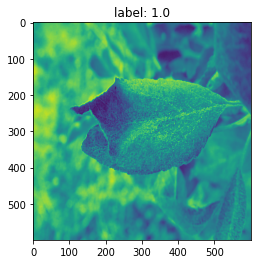

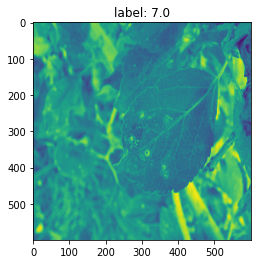

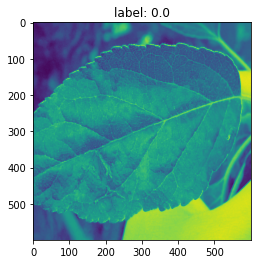

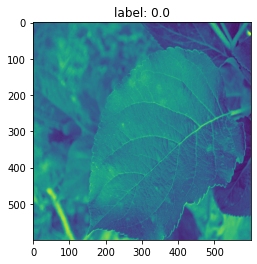

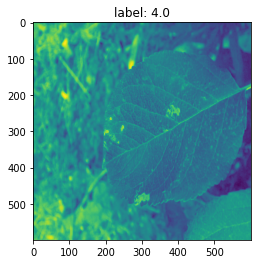

In [24]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show()

##Training func

In [25]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
  model.train()

  data_time = AverageMeter()
  losses = AverageMeter()

  start = end = time.time()

  para_loader = pl.ParallelLoader(train_loader, [device])

  for step, (images, labels) in enumerate(para_loader.per_device_loader(device)):
    optimizer.zero_grad()

    data_time.update(time.time() - end)
    
    batch_size = labels.size(0)

    images = images.to(device)
    labels = labels.to(device)
    
    y_preds = model(images)
    loss = criterion(y_preds, labels)
    losses.update(loss.item(), batch_size)

    loss.backward()
    xm.optimizer_step(optimizer, barrier=False)

    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), FLAGS['max_grad_norm'])
    
    end = time.time()

    if step % FLAGS['print_freq'] == 0 or step == (len(train_loader)-1):
      xm.master_print('TRIN:[{epoch:02}][{step:03}/{total}] '
                  'Time:{time}　'
 #                 'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch=epoch+1, step=step+1, total=len(train_loader),
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   time=datetime.datetime.fromtimestamp(end).strftime('%b %d, %Y %I:%M:%S%p')
                   ))
      #xm.master_print(profiler_client.monitor(tpu_profile_service_address, 100, 2))

  return losses.avg

In [26]:
def train_loop():
  
  serialized_train_dataset = train_dataset

  train_sampler = torch.utils.data.distributed.DistributedSampler(
      serialized_train_dataset,
      num_replicas=xm.xrt_world_size(),
      rank=xm.get_ordinal(),
      shuffle=True)
  
  train_loader = DataLoader(serialized_train_dataset,
                            batch_size=FLAGS['batch_size'],
                            sampler=train_sampler,
                            num_workers=FLAGS['num_workers'],
                            drop_last=True)
 
  device = xm.xla_device()

  model = WRAPPED_MODEL.to(device)

  optimizer = Adam(model.parameters(), lr=FLAGS['learning_rate'] , weight_decay=FLAGS['weight_decay'], amsgrad=False)

  scheduler = CosineAnnealingLR(optimizer, T_max=FLAGS['T_max'], eta_min=FLAGS['min_lr'], last_epoch=-1)

  criterion = nn.CrossEntropyLoss()

  for epoch in range(FLAGS['num_epochs']):

    train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

  xm.save(model.state_dict(), f"{FLAGS['OUTPUT_DIR']}{FLAGS['model_name']}.pth")


#Main

In [27]:
def _mp_fn(index, flags):
  train_loop()

#Parameters(Tuning)

In [28]:
#training
FLAGS['batch_size'] = 8
FLAGS['num_workers'] = 2
FLAGS['learning_rate'] = 2e-4
FLAGS['min_lr'] = 2e-5
FLAGS['T_max'] = 6e5
FLAGS['weight_decay'] = 1e-4
FLAGS['num_cores'] = 8
FLAGS['num_epochs'] = 2
FLAGS['print_freq'] = 100
FLAGS['max_grad_norm']=1e3

#Execute Main

In [ ]:
if __name__ == '__main__':

  #best_loss = Value('d', np.inf)

  xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'], start_method='fork')

#(Colab Only)Wrap up

##Upload models to Kaggle

In [ ]:
OUTPUT_DIR=FLAGS['OUTPUT_DIR']
%cd $OUTPUT_DIR

In [ ]:
#!kaggle datasets init -p ./

In [ ]:
ls -la

In [ ]:
!kaggle datasets create

In [ ]:
!kaggle datasets version -m versionup

##OOM memo

In [ ]:
#image_size=600, batch_size=16
#(0) Resource exhausted: Ran out of memory in memory space hbm. Used 8.27G of 7.98G
#16*600*x=8270M   x=0.86

#image size (y) when batch size16
#16*y*0.86<8000M    y<581   したがって８の倍数の576。

In [ ]:
#image_size=576, batch_size=16
#(0) Resource exhausted: Ran out of memory in memory space hbm. Used 8.04G of 7.98G hbm. Exceeded hbm capacity by 64.82M.
#16*576*576*x=8,270,000   x=1.557

In [ ]:
#Re-calc by square
#image_size=600, batch_size=16
#(0) Resource exhausted: Ran out of memory in memory space hbm. Used 8.27G of 7.98G
#16*600*600*x=8,270,000K  x=1.435

#image size (y) when batch size16
#16*y*y*1.435<8,000,000    y<590?

In [ ]:
#image_size=560, batch_size=16
# (0) Resource exhausted: Ran out of memory in memory space hbm. Used 8.01G of 7.98G hbm. Exceeded hbm capacity by 25.74M.

In [ ]:
#image_size=552, batch_size=16
#  (0) Resource exhausted: Ran out of memory in memory space hbm. Used 8.08G of 7.98G hbm. Exceeded hbm capacity by 100.82M.


In [ ]:
#image_size=520, batch_size=16
#  (0) Resource exhausted: Failed to allocate request for 60.94MiB 

In [ ]:
#image_size=496, batch_size=16
#  (1) Resource exhausted: Failed to allocate request for 46.50MiB (48758784B) on device ordinal 1

In [ ]:
#image_size=496, batch_size=16
#  (0) Resource exhausted: Failed to allocate request for 45.00MiB (47185920B) on device ordinal 4